In [ ]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
import math

In [ ]:
#build toy dataset
def generate_samples(n_samples_class):
    cov = np.array([[10, 2], [2, 1]])
    mean1 = np.array([0, 0])
    mean2 = np.array([0, 5])

    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 2))

    x[:n_samples_class, 0], x[:n_samples_class, 1] = np.random.multivariate_normal(mean1, cov, n_samples_class).T
    x[n_samples_class:, 0], x[n_samples_class:, 1]  = np.random.multivariate_normal(mean2, cov, n_samples_class).T

    labels = np.zeros(total_n_samples)
    labels[n_samples_class:] = 1
    return x, labels



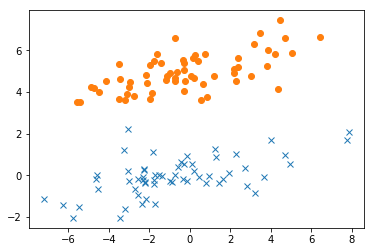

In [8]:
n_samples_class = 60
x, y  =  generate_samples(n_samples_class)
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')

plt.savefig("data_2d.png")
plt.show()

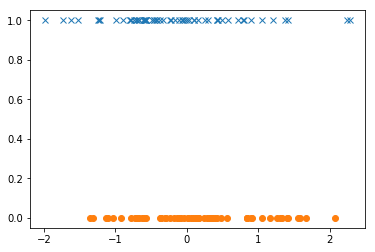

In [9]:
from sklearn.decomposition import FactorAnalysis
transformer = FactorAnalysis(n_components=1, random_state=0)
x_proj_fa_python = transformer.fit_transform(x)
f_fa_python = transformer.components_

plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.savefig('data_proj_fa_python')
plt.show()

In [95]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e): #check the order of arguments!
    sigma = 1 # variance for the noise in y
    N = x.shape[0]
    x_dim = x.shape[1]
    f, mean, cov, w = decode_parameters(params, x_dim, latent_dim)
        
    var_x = np.einsum("dl,ml->dm",f,f) + cov
    sign, log_det_var_x = np.linalg.slogdet(var_x)
    
    temp1 = np.linalg.solve(var_x, (x - mean).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - mean, temp1)
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w, mean_z)
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    l = log_det_var_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 - lambda_e*np.sum(log_bern_pdf_y) - log_prior
    return l 

def objective_norm (params, x, y, latent_dim, lambda_e): #check the order of arguments!
    sigma = 1 # variance for the noise in y
    N = x.shape[0]
    x_dim = x.shape[1]
    f, mean, cov, w = decode_parameters(params, x_dim, latent_dim)
        
    var_x = np.einsum("dl,ml->dm",f,f) + cov
    temp1 = np.einsum("dl,dm->lm", f, np.linalg.solve(var_x,f)) #in fact m=l <- latent dimension 
    var_z = np.identity(latent_dim) - temp1
    var_y = np.dot(w,np.dot(var_z,w)) + sigma**2
    sign, log_det_var_x = np.linalg.slogdet(var_x)
    a = log_det_var_x + lambda_e*np.log(var_y)
    
    temp2 = np.linalg.solve(var_x, (x - mean).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - mean, temp2)
    mean_z = np.einsum("dl,dn->nl", f, temp2)
    mean_y = np.einsum("l,nl->n", w, mean_z)
    unnorm_log_pdf_y = (y - mean_y)**2/var_y
    b = np.sum(unnorm_log_pdf_x) + lambda_e*np.sum(unnorm_log_pdf_y)
    
    log_prior = 0 #marginals of  f,mean,cov and m for regularization use gaussian priors later
    l = a*N*0.5 + b*0.5 - log_prior
    return l
def decode_parameters(params, x_dim, latent_dim):
    size_f = x_dim*latent_dim
    f =  params[:size_f]
    f =  f.reshape(x_dim, latent_dim)
    mean = params[size_f:size_f+x_dim]
    diag = params[size_f+x_dim:size_f+x_dim*2]
    cov = np.diag(np.log(1+np.exp(diag)))
    w = params[size_f+x_dim*2:]
    return f,mean,cov,w

In [163]:
latent_dim = 1 #suppose z is scalar
x_dim = 2      
params_size = x_dim*latent_dim + x_dim + x_dim + latent_dim 

params = np.random.rand(params_size)

f, mean, cov, w =  decode_parameters(params, x_dim, latent_dim)
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "mean: ", mean
print "cov matrix: ", cov
print "regression weights: ",w
print "initial obj value logit", objective_logit(params, x, y, latent_dim, 100)
print "initial obj value norm", objective_gaussian(params, x, y, latent_dim, 100)


Initial parameters
F: [[0.66826656]
 [0.84570417]]
slope [1.26551921]
mean:  [0.17595636 0.80026161]
cov matrix:  [[0.87666421 0.        ]
 [0.         1.23033911]]
regression weights:  [0.43449682]
initial obj value logit 7475.05745284799
initial obj value norm 3904.0556271632204


In [166]:
#run minimizer use ADAM instead?
def pcallback(x):
    f, mean, cov, w = decode_parameters(x, 2, 1)
    print f
    print cov
    print np.einsum("dl,ml->dm",f,f)
    
lambda_e = 1

grad_objective_logit = grad(objective_logit, argnum = 0)
params_optimizied_norm, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x,y,latent_dim,lambda_e))
f_logit, mean_logit, cov_logit, w_logit = decode_parameters(params_optimizied_norm, x_dim, latent_dim)
print "Final parameters_logit"
print "logit slope", f_logit[1]/f_logit[0]
print "F:", f_logit
print "mean: ", mean_logit
print "cov matrix: ", cov_logit
print "regression weights: ", w_logit
print "final objective value:", obj_value_logit

grad_objective_norm = grad(objective_norm, argnum = 0)
params_optimizied_norm, obj_value_norm, dict = fmin_l_bfgs_b(objective_norm, x0 = params, fprime = grad_objective_norm, args = (x,y,latent_dim,lambda_e))
f_norm, mean_norm, cov_norm, w_norm = decode_parameters(params_optimizied_norm, x_dim, latent_dim)
print "Final parameters_norm"
print "F:", f_norm
print "mean: ", mean_norm
print "cov matrix: ", cov_norm
print "regression weights: ", w_norm
print "final objective value:", obj_value_norm



Final parameters_logit
logit slope [3.06540756]
F: [[0.86316235]
 [2.64594439]]
mean:  [-0.49562369  2.44566773]
cov matrix:  [[8.19874798 0.        ]
 [0.         0.        ]]
regression weights:  [194.73091287]
final objective value: 363.0005596729934
Final parameters_norm
F: [[0.88389545]
 [2.70902068]]
mean:  [-0.68477004  1.86529734]
cov matrix:  [[8.20034259e+00 0.00000000e+00]
 [0.00000000e+00 1.49982091e-06]]
regression weights:  [0.56560351]
final objective value: 376.6209909492478


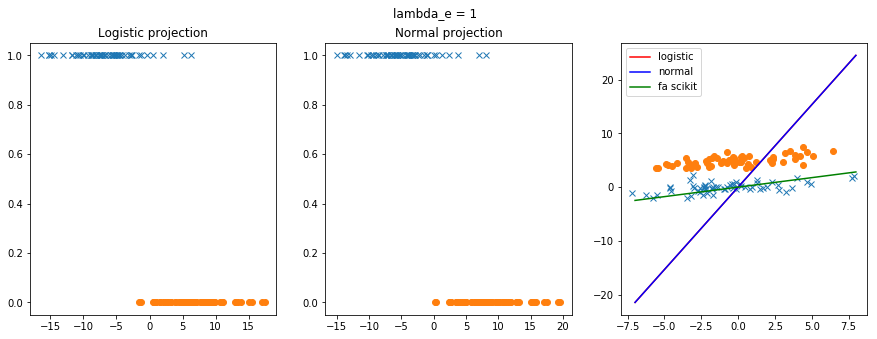

In [167]:
plt.figure(figsize=(15,5))

plt.subplot(131) 
plt.suptitle("lambda_e = {}".format(lambda_e))

plt.title("Logistic projection")
x_proj_logit = np.dot(x - mean_logit, f_logit)
plt.plot(x_proj_logit[:n_samples_class], np.ones(n_samples_class), 'x')
plt.plot(x_proj_logit[n_samples_class:], np.zeros(n_samples_class), 'o')

plt.subplot(132) 

plt.title("Normal projection")
x_proj_norm = np.dot(x - mean_norm, f_norm)
plt.plot(x_proj_norm[:n_samples_class], np.ones(n_samples_class), 'x')
plt.plot(x_proj_norm[n_samples_class:], np.zeros(n_samples_class), 'o')


plt.subplot(133) 
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')
a = np.array(range(int(round(np.min(x[:,0]))), 1+int(round(np.max(x[:,0]))))) 
b_pc_fa_logit = f_logit[1]/f_logit[0]*a 
b_pc_fa_norm = f_norm[1]/f_norm[0]*a 

b_std_fa = f_fa_python[0][1]/f_fa_python[0][0]*a

plt.plot(a, b_pc_fa_logit,  color ="r", label='logistic')
plt.plot(a, b_pc_fa_norm,  color ="b", label='normal')
plt.plot(a, b_std_fa, color ="g", label='fa scikit')
plt.legend()

plt.savefig("data_lambda_e={}_logistic_norm.png".format(lambda_e))
plt.show()

In [ ]:
for i in range (0,10):
    params = np.random.rand(params_size)
    f, mean, cov, w =  decode_parameters(params, x_dim, latent_dim)
  
    lambda_e = 0
    grad_objective = grad(objective, argnum = 0)
    params_optimizied, obj_value, dict = fmin_l_bfgs_b(objective, x0 = params, fprime = grad_objective, args = (x,y,latent_dim,lambda_e))
    f, mean, cov, w = decode_parameters(params_optimizied, x_dim, latent_dim)
    print i
    print "Final F:", f
    print "final objective value:", obj_value
    print "Final mean: ", mean
    print "Final cov matrix: ", cov
    plt.figure(figsize=(15,5))

    plt.subplot(121) 
    plt.suptitle("lambda_e = {}".format(lambda_e))

    x_proj = np.dot(x - mean, f)
    plt.plot(x_proj[:n_samples_class], np.ones(n_samples_class), 'x')
    plt.plot(x_proj[n_samples_class:], np.zeros(n_samples_class), 'o')

    plt.subplot(122) 
    plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
    plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')
    a = np.array(range(int(round(np.min(x[:,0]))), 1+int(round(np.max(x[:,0]))))) 
    b_pc_fa = f[1]/f[0]*a 
    b_std_fa = f_fa_python[0][1]/f_fa_python[0][0]*a
    plt.plot(a, b_pc_fa,  color ="r")
    plt.plot(a, b_std_fa, color ="g")
    plt.savefig("data_lambda_e=0, #{}.png".format(i))


In [ ]:
a = np.array([1,2,3])
b = np.array([3,4,5])
np.multiply(a,b)